# Imports

In [200]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
# from tensorflow_addons.losses import pinball_loss
from tensorflow import function as tf_fun
from tensorflow import keras
from tensorflow.keras import Model
from math import log, sqrt, exp, erf, ceil, floor
from tqdm.notebook import tqdm, trange
import pandas as pd
from math import ceil

import scipy.stats as stats
from scipy.stats import qmc
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter
from scipy.stats import norm
from matplotlib import ticker

from importlib import reload

from numpy.random import seed   
from tensorflow.random import set_seed as tf_seed

tf_seed(1234) ; seed(1234)

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

# Simulate W1 & W2 Pahs

In [201]:
# Sobol - Quasi Monte Carlo for path simulation
def sobol_norm(m, d=1 ,seed=1234):
    sampler = qmc.Sobol(d, scramble=True, seed=seed)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

In [252]:
""" Global Variables """
n_paths   = ceil(np.log2(4_000)) ; print(f'Paths: {2**n_paths:,.0f}')# for both Y and N
dt        = 1/(365) # Local: use greater than 42

rebalancing = 1/4 # Quarterly

P = 100 # premium per client
N = 10_000
ADJUSTMENT_FACTOR = P * N

Paths: 4,096


## Y - Geometric Brownian Motion

Number of steps: 3651 
dt         = 0.003 year
----------------------------------------------------------------
Time to simulate: 0.944sec
mean Yt    = 2.227189
e^(mu * T) = 2.225541 
Diff       = 0.001648


[]

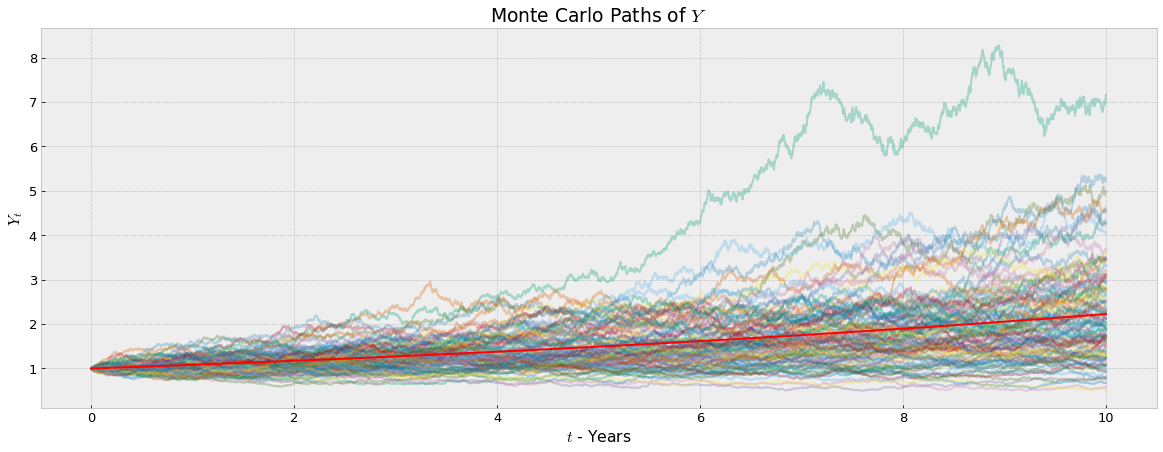

In [253]:
Y       = 1 # Starting value of stock
T       = 10 # Years
mu      = 0.08 #drift parameter
r       = 0.03 # risk
sigma   = 0.15

n_time_steps = ceil(T/dt)+1 ; print(f'Number of steps: {n_time_steps} \ndt         = {dt:.3f} year')

timer=perf_counter()

""" Simulate Fund Price """
W1      = sobol_norm(n_paths, d=n_time_steps, seed=1235)
Y_paths = np.empty((2**n_paths, n_time_steps))
Y_paths[:,0] = Y

print('----------------------------------------------------------------')
for t in range(1,n_time_steps):
    Y_paths[:,t] = Y_paths[:,t-1] + Y_paths[:,t-1] * (mu*dt + sigma * np.sqrt(dt)*W1[:,t]).squeeze()

""" Generate Bond Data """
B = np.exp(r*np.linspace(0,T, n_time_steps))
B = np.broadcast_to(B, Y_paths.shape)
print(f'Time to simulate: {perf_counter()-timer:.3f}sec')

print(f'mean Yt    = {np.nanmean(Y_paths[:,-1]):.6f}')
print(f'e^(mu * T) = {np.exp(mu*T):.6f} \nDiff       = {np.nanmean(Y_paths[:,-1])-Y*np.exp(mu*T):.6f}')

rdf = pd.DataFrame(Y_paths.T, index=(np.linspace(0,T, n_time_steps)))
ax = rdf.sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$Y_t$', xlabel=r'$t$ - Years', title=r'Monte Carlo Paths of $Y$') 
ax.plot(np.linspace(0,T, n_time_steps), np.exp(mu*np.linspace(0,T, n_time_steps)), c='r') ; plt.plot()


# N(T) - Simulation

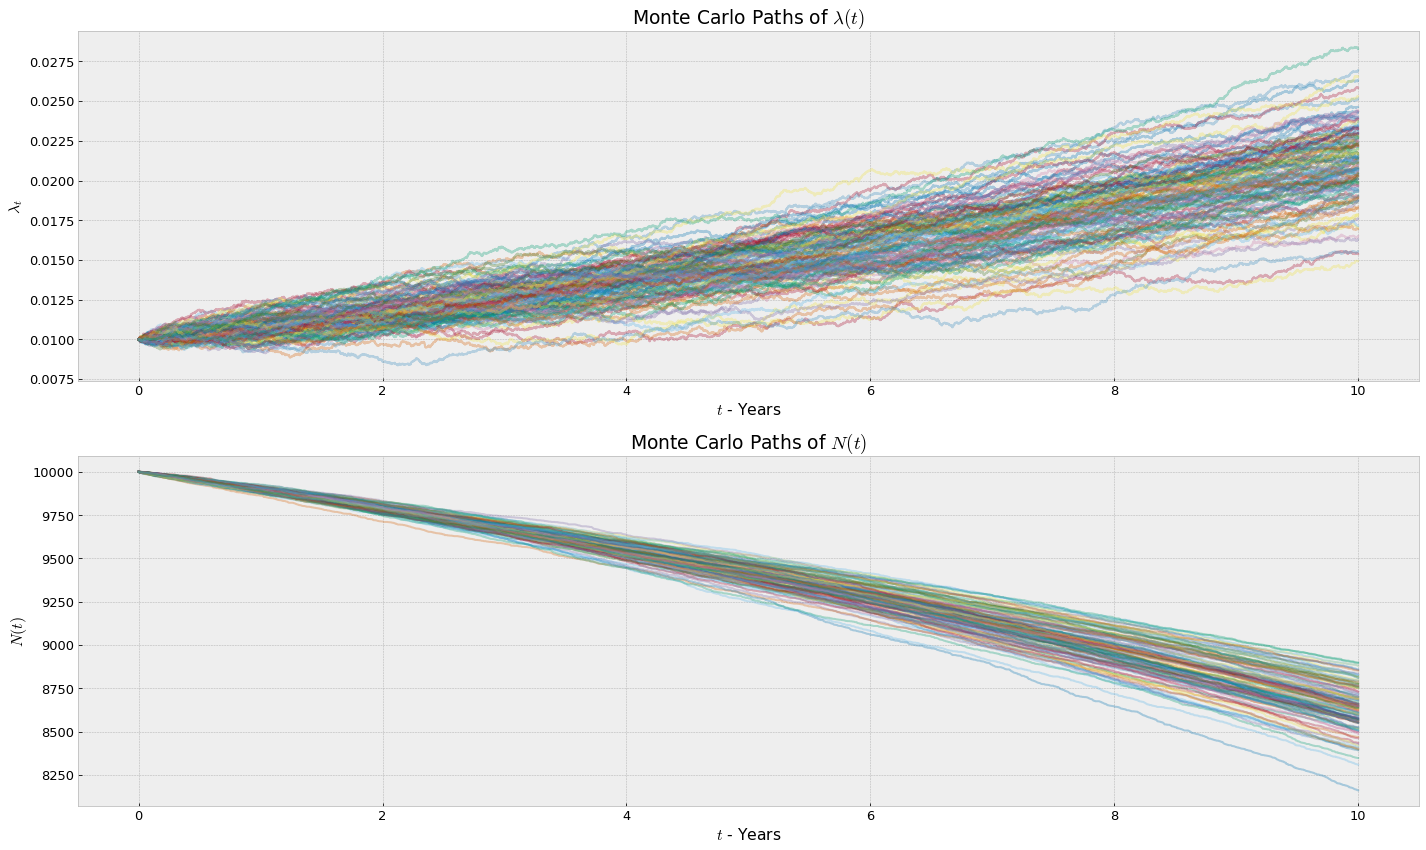

Statistics about N(T) 
---------------------
count   4,096
mean    8,617
std       133
min     8,114
50%     8,617
90%     8,789
95%     8,838
99%     8,930
max     9,200


In [254]:
x   = 55.0 # years old
l0  = 0.01
c   = 0.075
ita = 0.000597

W2      = sobol_norm(n_paths, d=n_time_steps)
L_paths = np.empty((2**n_paths, n_time_steps))
L_paths[:,0] = l0
for t in range(1,n_time_steps):
    L_paths[:,t] = L_paths[:,t-1] + (c * L_paths[:,t-1] * dt + ita * np.sqrt(dt)*W2[:,t]).squeeze()

N_paths = np.empty((2**n_paths, n_time_steps), dtype=int)
N_paths[:,0] = N
""" Binomial Distribution of N(t) """
for t in range(1,n_time_steps):
    probabilities = np.exp(-L_paths[:,t]*dt)
    np.random.seed(1234+t) # to ensure reproducible results
    N_paths[:,t]  = np.random.binomial(N_paths[:,t-1], probabilities)

fig, axs = plt.subplots(2, figsize=(20,12))

Ldf = pd.DataFrame(L_paths.T, index=(np.linspace(0,T, n_time_steps)))
Ldf.sample(128, axis=1).plot(drawstyle="steps-post", legend=False, alpha=.3, ylabel=r'$\lambda_t$', xlabel=r'$t$ - Years', ax=axs[0], title=r'Monte Carlo Paths of $\lambda(t)$') 

Ndf = pd.DataFrame(N_paths.T, index=(np.linspace(0,T, n_time_steps)))
Ndf.sample(128, axis=1).plot(legend=False, alpha=.3, ylabel=r'$N(t)$', xlabel=r'$t$ - Years', ax=axs[1], title=r'Monte Carlo Paths of $N(t)$') 

plt.tight_layout() ; plt.show()

str_form = lambda s: f'{s:,.0f}'
print('Statistics about N(T) \n---------------------')
print(Ndf.loc[10].describe(percentiles=[.90, .95, .99]).to_string(float_format=str_form))


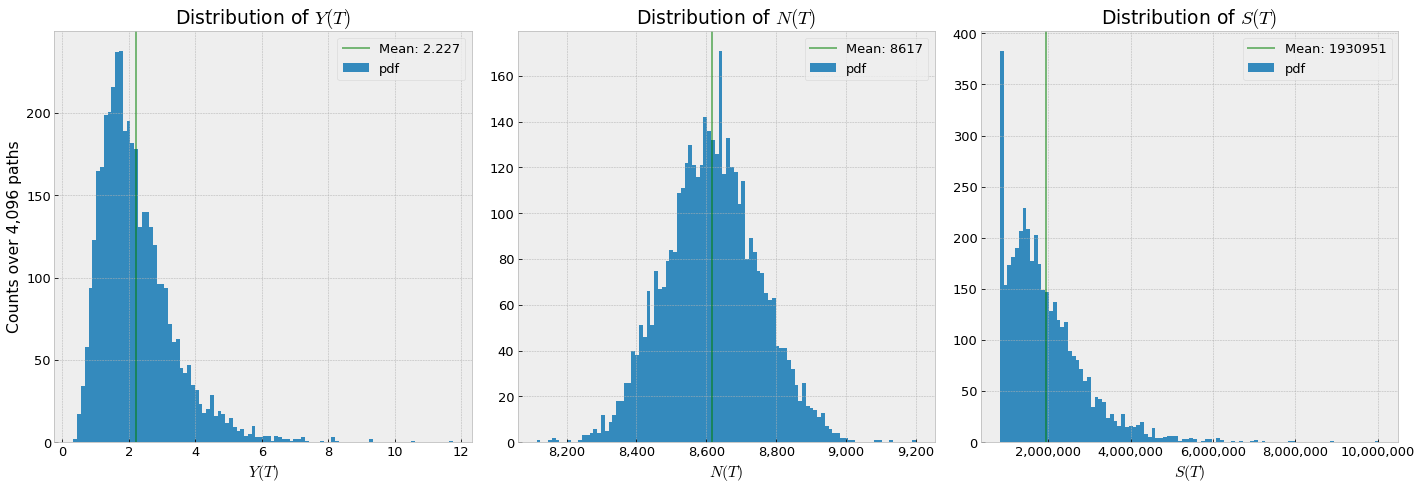

-------------------------------------
E[Y(T)]          = 2.241
E[Y(T)]*e^(-r*T) = 1.660
Prob Y(T) < Y(0) = 7.42%


In [255]:
""" Y, N, S - Plots """
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

# Y plot
payoff_df = pd.Series(Y_paths[:,-1])
payoff_df.hist(bins=100, ax=ax1) ; ax1.set_title(r'Distribution of $Y(T)$')
ax1.axvline(payoff_df.mean(), color='g', linestyle='-', alpha=.5)
ax1.legend([f'Mean: {payoff_df.mean():.3f}', 'pdf'])
ax1.set_xlabel(r'$Y(T)$') ; ax1.set_ylabel(f'Counts over {Y_paths.shape[0]:,} paths')

# N(T) plot
E_N_T   = N_paths[:,-1].mean()
N_T     = pd.Series(N_paths[ N_paths[:,-1]>0 ,-1])
N_T.hist(bins=100, ax=ax2) ; ax2.set_title(r'Distribution of $N(T)$')
ax2.axvline(E_N_T, color='g', linestyle='-', alpha=.5)
ax2.legend([f'Mean: {E_N_T:.0f}', 'pdf'])
ax2.set_xlabel(r'$N(T)$')
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Liability S(T) plot
Payoff_Y     = np.where(Y_paths[:,-1] > Y, Y_paths[:,-1], Y)

S_T = Payoff_Y * P * N_paths[:,-1]
S_T_df = pd.Series(S_T)
S_T_df.hist(bins=100, ax=ax3) ; ax3.set_title(r'Distribution of $S(T)$')
ax3.axvline(S_T_df.mean(), color='g', linestyle='-', alpha=.5)
ax3.legend([f'Mean: {S_T_df.mean():.0f}', 'pdf'])
ax3.set_xlabel(r'$S(T)$') ; axs[1].set_ylabel(f'Density over {Y_paths.shape[0]:,} paths')
ax3.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

fig.tight_layout() ; plt.show()

# Liability statistics
print('-------------------------------------')
out_of_money_P  = np.where(Y_paths[:,-1] < Y, 1.0, 0.0).mean()
print(f'E[Y(T)]          = {Payoff_Y.mean():.3f}')
print(f'E[Y(T)]*e^(-r*T) = {np.exp(-r*T)*Payoff_Y.mean():.3f}')
print(f'Prob Y(T) < Y(0) = {out_of_money_P*100:.2f}%')

In [256]:
# print(f'Y_paths.shape = {Y_paths.shape}')
reduction       = floor((n_time_steps-1)/(T/rebalancing))   ; print(f'reduction = {reduction}')
Y_paths         = Y_paths[:, slice(0, None, reduction)]
B               = B[:, slice(0, None, reduction)]
N_paths         = N_paths[:, slice(0, None, reduction)]
n_time_steps  = ceil(n_time_steps/reduction) ; dt = dt *(reduction)
Y_paths[:,-1].mean(), N_paths[:,-1].mean(), dt, Y_paths.shape, n_time_steps

reduction = 91


(2.2221566232175243, 8622.1201171875, 0.2493150684931507, (4096, 41), 41)

# Liability S(t)
$$ S_T = N(T)*max(Y_T,Y_0)*Premium $$
$$ E[S_T] = avg(S_T) $$

Expected S_T = 1,932,065 EUR


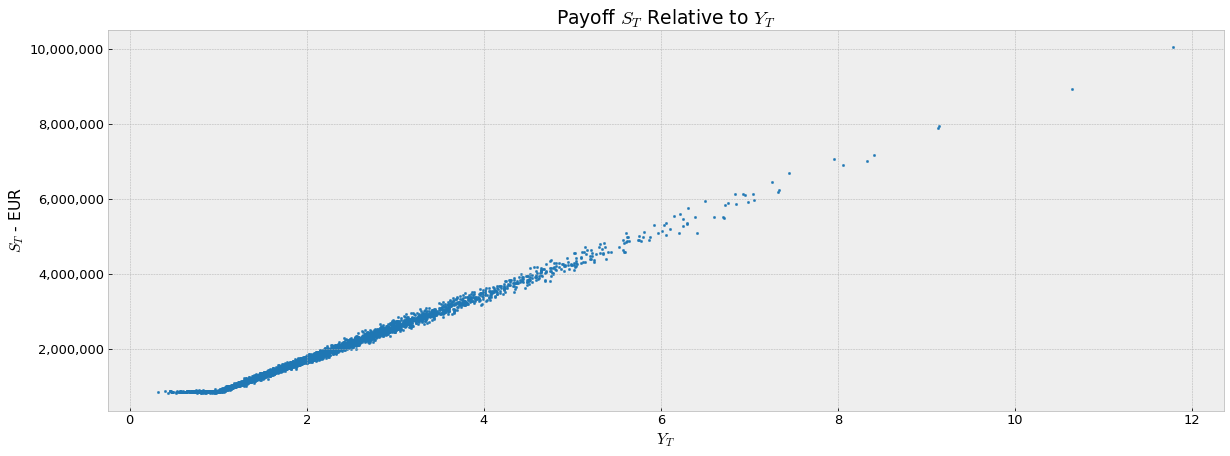

In [257]:
S_T = Payoff_Y * N_paths[:, -1] * P
_in = {'S_T': S_T, 'Y_T': Y_paths[:,-1]}
ax = pd.DataFrame.from_dict(_in).plot(kind='scatter', x='Y_T', y='S_T',xlabel=r'$Y_T$',ylabel=r'$S_T$ - EUR', title=r'Payoff $S_T$ Relative to $Y_T$', marker='.', color='tab:blue')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
print(f'Expected S_T = {S_T.mean():,.0f} EUR')

# Neural Network Hedging

In [258]:
def get_phi_psi_VaR(model1, model2, X0, Phi_Psi_HV, VaR_HV, cost_of_capital, values, Y_t, B_t):
    layer_output1=model1.get_layer('Phi_Psi').output
    pw_model1 = Model(inputs=[model1.input], outputs=[layer_output1])

    linear_layer_output1 = pw_model1.predict(X0)

    layer_output2 = model2.get_layer('Phi_Psi').output
    pw_model2 = Model(inputs=[model2.input], outputs=[layer_output2])

    linear_layer_output2 = pw_model2.predict(X0)

    phi = linear_layer_output1[:,0] + cost_of_capital * (linear_layer_output1[:,0] - linear_layer_output2[:,0])
    psi = linear_layer_output1[:,1] + cost_of_capital * (linear_layer_output1[:,1] - linear_layer_output2[:,1])

    for f  in phi: Phi_Psi_HV.append([f,  t_i*dt, 'Phi'])
    for ps in psi: Phi_Psi_HV.append([ps, t_i*dt, 'Psi'])

    VaR = values - phi * Y_t - psi * B_t

    print(f'VaR: {np.quantile(VaR, .98):4f} (98%),  {np.quantile(VaR, .99):4f} (99%)')
    for var in VaR: VaR_HV.append([var, (t_i+1)*dt])
    
    return Phi_Psi_HV, VaR_HV


def scheduler(epoch, lr):
    if epoch < 100 :
        return 1e-2
    elif epoch < 200 :
        return 1e-3
    elif epoch < 400 :
        return 5e-4
    else:
        return lr

@tf_fun
def quantile_loss(y, y_p):
        QUANTILE = .99
        e = y-y_p
        return keras.backend.mean(keras.backend.maximum(QUANTILE*e, (QUANTILE-1)*e))

lr_scheduler    = keras.callbacks.LearningRateScheduler(scheduler)
quantile_loss_f = lambda y, y_p : quantile_loss(y, y_p)

In [259]:
cost_of_capital = .1 

In [260]:
dense_initalizer = keras.initializers.RandomNormal(mean=0, stddev=0.1, seed=1234)
const_initalizer = keras.initializers.RandomNormal(mean=[1-out_of_money_P,out_of_money_P], stddev=0.0, seed=1234)

# model 1
Input_S_N = keras.Input(shape=(3,), name='input: S_{t}, N_{t}, l_{t}') 
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S_N)
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x)
holdings = keras.layers.Dense(2, activation='linear', name='Phi_Psi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x)

prices_1 = keras.Input(shape=(2,), name='input: S_{t}, B_{t}')
S_out    = keras.layers.Dot(axes = 1, name='V_t')([holdings, prices_1]) 

model1 = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio_MSE")

#model2
Input_S_N2 = keras.Input(shape=(3,), name='input: S_{t}, N_{t}, l_{t}') 
x2 = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S_N2)
x2 = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x2)
holdings2 = keras.layers.Dense(2, activation='linear', name='Phi_Psi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x2)

prices_12 = keras.Input(shape=(2,), name='input: S_{t}, B_{t}')
S_out2    = keras.layers.Dot(axes = 1, name='V_t')([holdings2, prices_12]) 

model2 = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio_Q99")
model1.summary()

Model: "Replicating_Portfolio_MSE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input: S_{t}, N_{t}, l_{t} (Inp [(None, 3)]          0                                            
__________________________________________________________________________________________________
LeakyReLU_1 (Dense)             (None, 8)            32          input: S_{t}, N_{t}, l_{t}[0][0] 
__________________________________________________________________________________________________
LeakyReLU_2 (Dense)             (None, 8)            72          LeakyReLU_1[0][0]                
__________________________________________________________________________________________________
Phi_Psi (Dense)                 (None, 2)            18          LeakyReLU_2[0][0]                
__________________________________________________________________________

In [261]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model1.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = 'mse', run_eagerly=False, 
              metrics=["mae", "mape"])
model2.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = quantile_loss_f, run_eagerly=False, 
              metrics=["mae", "mape"])

N_paths_NN      = N_paths / N
values          = np.empty_like(Y_paths)
values[:,-1]    = Payoff_Y * N_paths_NN[:,-1] 
E_payoff        = (values[:,-1]).mean()

""" Calculate: Payoff for Options """
Flag = True ; its = 0
Errors      = np.zeros((1,2))
P_E_Values  = np.ones((1,3)) * values[:,-1].mean()
VaR_HV      = []
Phi_Psi_HV  = []
for t_i in trange(n_time_steps-2, -1, -1):
    print(f'Y_({(t_i+1)*dt:.2f}) = {Y_paths[:,t_i+1].mean():.3f}, N_({(t_i+1)*dt:.2f}) = {N_paths_NN[:,t_i+1].mean():.3f}')
    _Y_t  = Y_paths[:,t_i]
    _B_t  = B[:,t_i]
    _Y_t1 = Y_paths[:,t_i+1]
    _B_t1 = B[:,t_i+1]

    X0 = [np.stack((_Y_t, N_paths_NN[:,t_i], L_paths[:,t_i]), axis=-1), np.stack((_Y_t, _B_t), axis=-1)]
    X1 = [np.stack((_Y_t, N_paths_NN[:,t_i], L_paths[:,t_i]), axis=-1), np.stack((_Y_t1, _B_t1), axis=-1)]

    epochs = 500
    if Flag :
        # print(f'S.mean: {S.mean():.5f}\nP.mean: {model.predict(X0, verbose=0, batch_size=512).squeeze().mean():.5f}')
        callabacks = [lr_scheduler, keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)]
    else : 
        epochs = 100 
        callabacks = [callback]

    model1.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)
    g_t  = model1.predict(X0, verbose=0, batch_size=512).squeeze()
    g_t1 = model1.predict(X1, verbose=0, batch_size=512).squeeze()

    Errors = np.append(Errors, np.array(model1.evaluate(X1, values[:,t_i+1], batch_size=512)[1:]).reshape(1,2), axis=0)
    
    model2.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)    
    h_t  = model2.predict(X0, verbose=0, batch_size=512).squeeze()
    h_t1 = model2.predict(X1, verbose=0, batch_size=512).squeeze()

    values[:,t_i] = g_t + cost_of_capital*(h_t - g_t)

    """ Update phi-psi and VaR """
    Phi_Psi_HV, VaR_HV = get_phi_psi_VaR(model1, model2, X0, Phi_Psi_HV, VaR_HV, cost_of_capital, values[:,t_i+1], _Y_t1, _B_t1)

    its += 1 ; Flag = False 
    P_E_Values = np.append(P_E_Values, np.array([values[:,t_i].mean(), E_payoff*np.exp(-mu*dt*its), E_payoff*np.exp(-r*dt*its)]).reshape(1,3), axis=0)


  0%|          | 0/40 [00:00<?, ?it/s]

Y_(9.97) = 2.222, N_(9.97) = 0.862
8/8 [==============================] - 0s 7ms/step - loss: 0.0038 - mae: 0.0446 - mape: 2.3568
VaR: -0.014872 (98%),  -0.000659 (99%)
Y_(9.72) = 2.178, N_(9.72) = 0.867
8/8 [==============================] - 0s 4ms/step - loss: 1.0017e-04 - mae: 0.0051 - mape: 0.4067
VaR: -0.002255 (98%),  -0.001548 (99%)
Y_(9.47) = 2.134, N_(9.47) = 0.871
8/8 [==============================] - 0s 5ms/step - loss: 6.9212e-05 - mae: 0.0032 - mape: 0.3130
VaR: -0.000586 (98%),  -0.000185 (99%)
Y_(9.22) = 2.090, N_(9.22) = 0.876
8/8 [==============================] - 0s 4ms/step - loss: 7.6944e-05 - mae: 0.0034 - mape: 0.3331
VaR: -0.003682 (98%),  -0.002337 (99%)
Y_(8.98) = 2.048, N_(8.98) = 0.880
8/8 [==============================] - 0s 4ms/step - loss: 5.9951e-05 - mae: 0.0031 - mape: 0.3014
VaR: -0.000347 (98%),  -0.000077 (99%)
Y_(8.73) = 2.009, N_(8.73) = 0.884
8/8 [==============================] - 0s 7ms/step - loss: 6.2109e-05 - mae: 0.0033 - mape: 0.3181
VaR: 

# Residuals - VaR
* Add N(t) Notation
* 3 graphs - payoff , first hedge and after the last

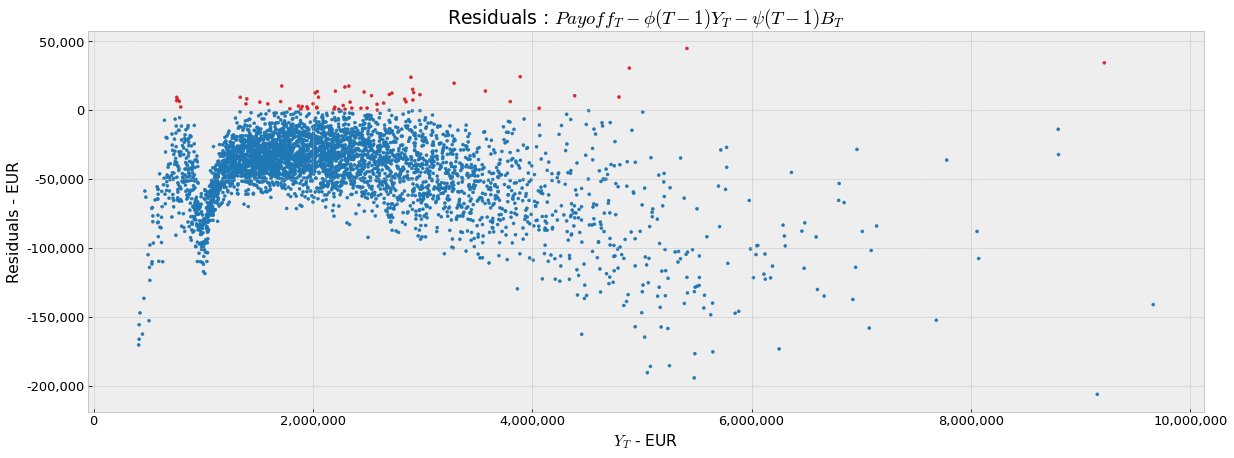

In [243]:
VaR_HV_df = pd.DataFrame(np.array(VaR_HV)[:,0], index=np.array(VaR_HV)[:,1], columns=['VaR'])
VaR_HV_df = VaR_HV_df * ADJUSTMENT_FACTOR
residuals = VaR_HV_df.loc[10].values 
c = ['tab:red' if r else 'tab:blue' for r in residuals > 0]
fig, ax = plt.subplots()
plt.scatter(Y_paths[:,-1]* ADJUSTMENT_FACTOR, residuals, color=c, marker='.')
plt.xlabel(r'$Y_{T}$ - EUR'), plt.ylabel('Residuals - EUR')
plt.title(r'Residuals : $Payoff_T - \phi(T-1)Y_T - \psi(T-1)B_T$')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

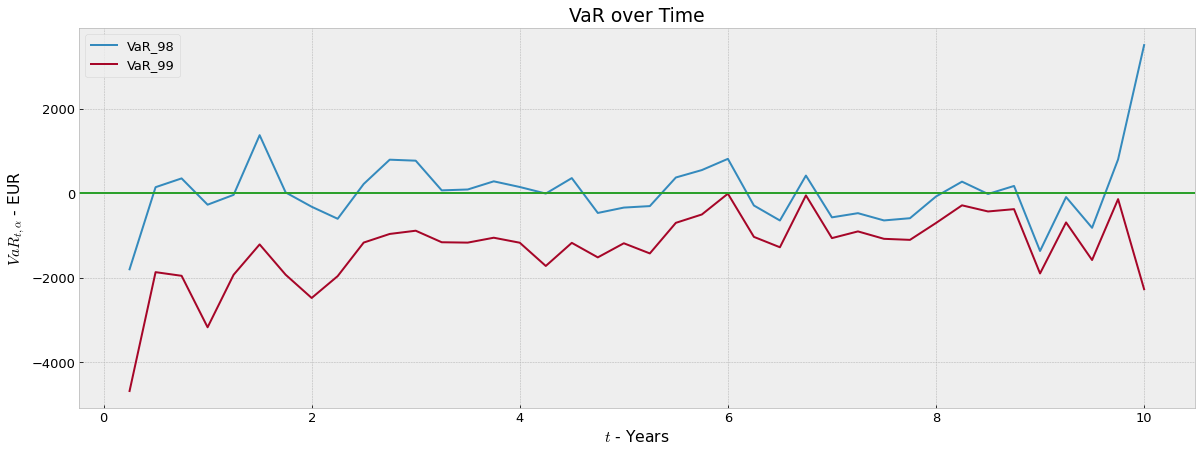

Overall VaR(98.5%) = -492.69 EUR
Overall VaR(99.0%) = 79.97 EUR
Overall VaR(99.5%) = 1464.14 EUR


In [249]:
ax = VaR_HV_df.groupby(level=0).aggregate(
    VaR_98=pd.NamedAgg(column="VaR", aggfunc = lambda x: np.quantile(x, .99)),
    VaR_99=pd.NamedAgg(column="VaR", aggfunc = lambda x: np.quantile(x, .98)),
    ).plot(title=r'VaR over Time', xlabel=r'$t$ - Years', ylabel=r'$VaR_{t,\alpha}$ - EUR')
ax.axhline(0, color='tab:green') ; plt.show()
print(f'Overall VaR(98.5%) = {np.quantile(VaR_HV_df.values, .985):.2f} EUR')
print(f'Overall VaR(99.0%) = {np.quantile(VaR_HV_df.values, .99):.2f} EUR')
print(f'Overall VaR(99.5%) = {np.quantile(VaR_HV_df.values, .995):.2f} EUR')

# Hedging Values

Phi t=0 : 635,053 Stocks
Psi t=0 : 342,816 Bonds


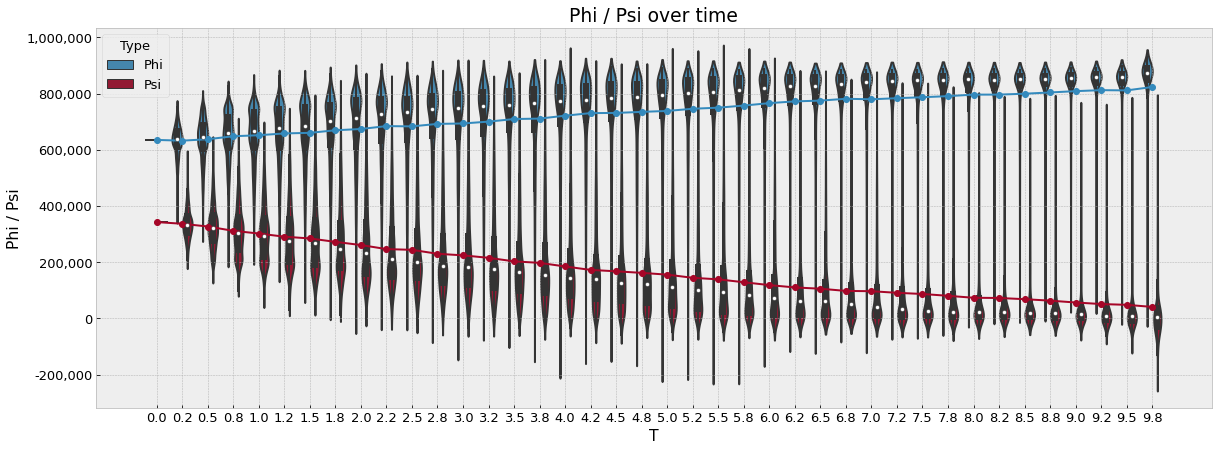

In [250]:
index = np.linspace(0, T, n_time_steps-1, endpoint = False)[::-1]
phi_psi_df = pd.DataFrame(Phi_Psi_HV, columns=['Value', 'T', 'Type'])
phi_psi_df.Value *= ADJUSTMENT_FACTOR 

ax = sns.violinplot(data=phi_psi_df, x="T", y="Value", hue="Type", dodge=1, cut=True)
ax.set_xticklabels([f'{x:,.1f}'for x in index][::-1])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

_ppg = phi_psi_df.groupby(['T', 'Type']).agg('mean')

title = 'Distribution of Phi/Psi over time'
phidf = _ppg.loc[_ppg.index.get_level_values('Type') == 'Phi'].groupby('T').mean().rename(columns={'Value':'Mean Phi'})['Mean Phi']
psidf = _ppg.loc[_ppg.index.get_level_values('Type') == 'Psi'].groupby('T').mean().rename(columns={'Value':'Mean Psi'})['Mean Psi']
phidf.index = range(0, phidf.shape[0]) ; psidf.index = range(0, psidf.shape[0])
phidf.plot(marker='o', ax=ax) ; psidf.plot(marker='o', ax=ax) ; 
ax.set_ylabel('Phi / Psi') ; ax.set_title('Phi / Psi over time') #; ax.set_xlabel('T - Years')

print(f'Phi t=0 : {_ppg.loc[(0, "Phi")].mean():,.0f} Stocks')
print(f'Psi t=0 : {_ppg.loc[(0, "Psi")].mean():,.0f} Bonds')

# _ppg

ADJUSTED 
--------------------------------------------
Value at t_0 (Replicating-P)  = 964,857.876
Discounted Eq[S] ADJ          = 1,430,494.533
 Difference                   = -465,636.657 : -32.551%
Discounted Ep[S] ADJ          = 867,638.793
 Difference                   = 97,219.083   : 11.205% 
Total Premium at t0           = 1,000,000 
Profit w/o TC                 = 35,142


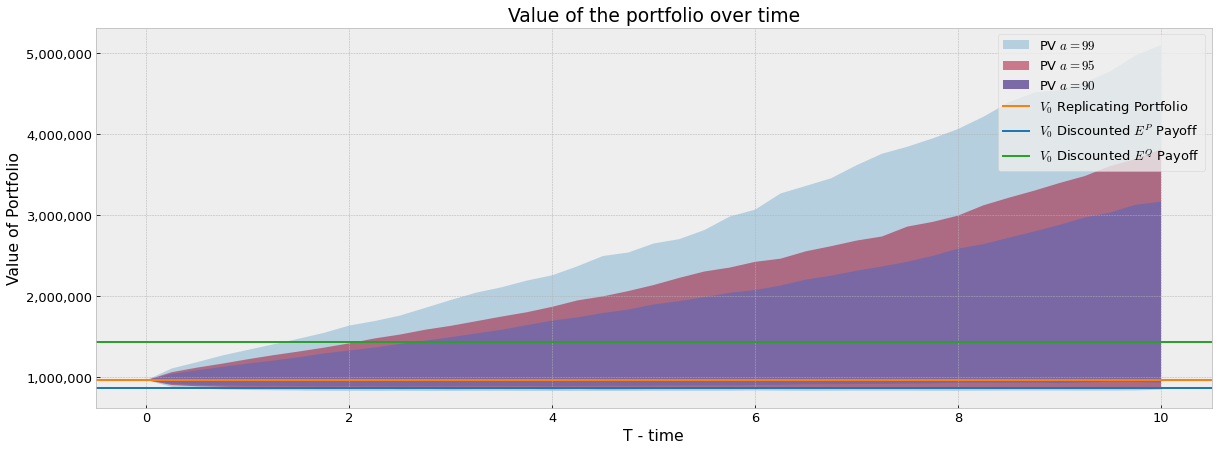

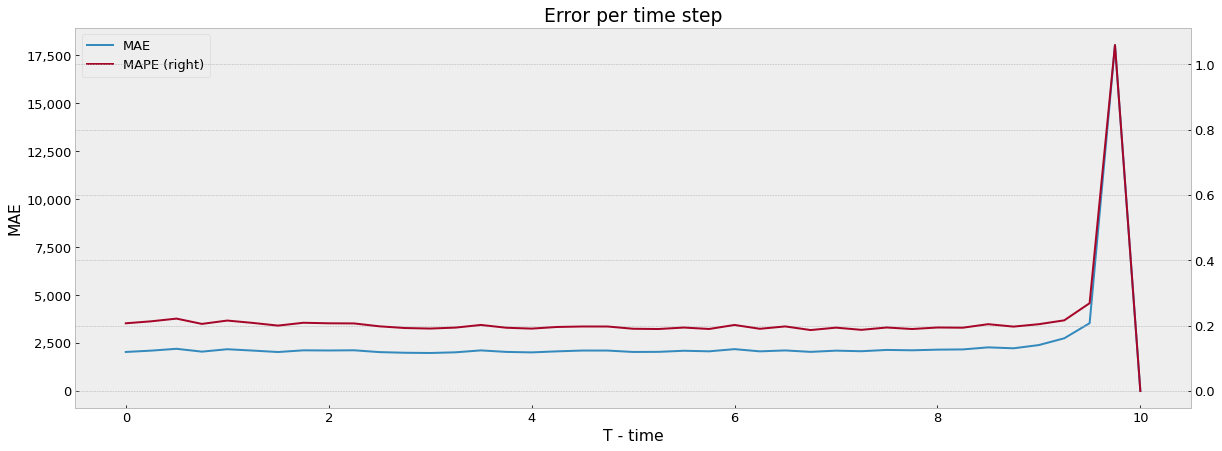

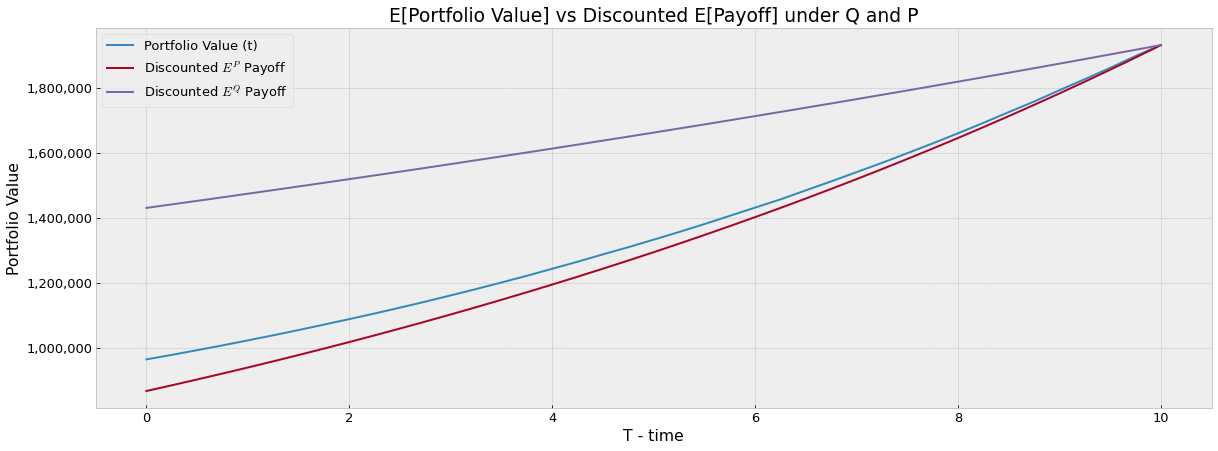

In [251]:
V0_RP = values[:,0].mean() * ADJUSTMENT_FACTOR

qs = np.quantile(values, q=[.99, .95, .9, .1, .05, .01], axis=0) * ADJUSTMENT_FACTOR
t  = np.linspace(0, T, n_time_steps)

fig, ax = plt.subplots()
ax.fill_between(t, qs[0,:].squeeze(), qs[-1,:].squeeze(), alpha=.3)
ax.fill_between(t, qs[1,:].squeeze(), qs[-2,:].squeeze(), alpha=.5)
ax.fill_between(t, qs[2,:].squeeze(), qs[-3,:].squeeze(), alpha=.99)
plt.ticklabel_format(style='plain', useLocale=True)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

ax.axhline(V0_RP, color='tab:orange')
ax.axhline(S_T.mean() * np.exp(-mu*T), color='tab:blue')
ax.axhline(S_T.mean() * np.exp(-r*T), color='tab:green')
ax.legend([r'PV $a=99$',r'PV $a=95$',r'PV $a=90$', r'$V_0$ Replicating Portfolio', r'$V_0$ Discounted $E^P$ Payoff', r'$V_0$ Discounted $E^Q$ Payoff'])
ax.set_xlabel('T - time') ; ax.set_ylabel('Value of Portfolio') ; ax.set_title('Value of the portfolio over time')

print('ADJUSTED \n--------------------------------------------')
print(f'Value at t_0 (Replicating-P)  = {V0_RP:,.3f}')
print(f'Discounted Eq[S] ADJ          = {S_T.mean() * np.exp(-r*T):,.3f}')
print(f' Difference                   = {V0_RP - S_T.mean() * np.exp(-r*T):,.3f} : {(V0_RP - S_T.mean() * np.exp(-r*T))/(S_T.mean() * np.exp(-r*T)) * 100:,.3f}%')
print(f'Discounted Ep[S] ADJ          = {S_T.mean() * np.exp(-mu*T):,.3f}')
print(f' Difference                   = {V0_RP - S_T.mean() * np.exp(-mu*T):,.3f}   : {(V0_RP - S_T.mean() * np.exp(-mu*T))/ (S_T.mean() * np.exp(-mu*T)) * 100:,.3f}% ')
print(f'Total Premium at t0           = {ADJUSTMENT_FACTOR:,} \nProfit w/o TC                 = {ADJUSTMENT_FACTOR - V0_RP:,.0f}')

Errors_df = pd.DataFrame(np.array(Errors[::-1]), index=t, columns=['MAE', 'MAPE'])
Errors_df['MAE'] = Errors_df['MAE'] * ADJUSTMENT_FACTOR
ax = Errors_df.plot(legend=True, title='Error per time step', ylabel='MAE', secondary_y=['MAPE'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) ; ax.set_xlabel('T - time')

E_Port_Values_df = pd.DataFrame(np.array(P_E_Values[::-1]), index=t, columns=['Portfolio Value (t)', r'Discounted $E^P$ Payoff', r'Discounted $E^Q$ Payoff']) * ADJUSTMENT_FACTOR
ax = E_Port_Values_df.plot(legend=True, title='E[Portfolio Value] vs Discounted E[Payoff] under Q and P', ylabel='Portfolio Value')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) ; ax.set_xlabel('T - time')

plt.show()

# Hedging Simulations - Simple Model

In [296]:
parameters = {
    # """ Financial parameters """
    'Y'       : 1,
    'K'       : 1,
    'T'       : 10, # Years
    'mu'      : 0.08,
    'r'       : 0.03,
    'sigma'   : 0.15,

    'rebalancing' : 1/1,

    # """ Acturial Parameters """
    'N'   : 10_000,
    'P'   : 100,
    'x'   : 55.0, # yo
    'l0'  : 0.01,
    'c'   : 0.075,
    'ita' : 0.000597,

    # """ Simulation parameters """
    'dt'      : 1/(100),
    'n_paths'  : ceil(np.log2(1_000))
}
import Replicating_Portfolio as RP
reload(RP)

phi, psi = RP.Replicating_Portfolio(parameters)

print(f'\n\nPhi t=0 : {phi:,.0f} Stocks')
print(f'Psi t=0 : {psi:,.0f} Bonds')

reduction = 100


  0%|          | 0/10 [00:00<?, ?it/s]


>> Y_(10.00) = 2.229, N_(10.00) = 0.862
2/2 [==============================] - 0s 10ms/step - loss: 0.0018 - mae: 0.0305 - mape: 1.8884
VaR: -0.006013 (98%),  -0.000235 (99%)

>> Y_(9.00) = 2.054, N_(9.00) = 0.880
2/2 [==============================] - 0s 15ms/step - loss: 3.2283e-04 - mae: 0.0093 - mape: 0.8558
VaR: -0.036647 (98%),  -0.027482 (99%)

>> Y_(8.00) = 1.893, N_(8.00) = 0.896
2/2 [==============================] - 0s 16ms/step - loss: 3.9551e-04 - mae: 0.0161 - mape: 1.1429
VaR: -0.020706 (98%),  -0.009814 (99%)

>> Y_(7.00) = 1.747, N_(7.00) = 0.912
2/2 [==============================] - 0s 6ms/step - loss: 2.1496e-04 - mae: 0.0091 - mape: 0.8252
VaR: -0.023342 (98%),  -0.014917 (99%)

>> Y_(6.00) = 1.614, N_(6.00) = 0.927
2/2 [==============================] - 0s 14ms/step - loss: 1.4875e-04 - mae: 0.0076 - mape: 0.7141
VaR: -0.019558 (98%),  -0.012925 (99%)

>> Y_(5.00) = 1.492, N_(5.00) = 0.941
2/2 [==============================] - 0s 4ms/step - loss: 9.1068e-05 - ma